### Coding 3: Final Assignment - Bechdel Test Investigation
#### Peter Endes-Nagy and Nadine Levin

## Introduction

Lorem ipsum

*Ideas*
1. Scrape IMDb site for LGBT films of last 10 years to compare to popular films of last 10 years
2. Investigate if LGBT films score higher on the Bechdel test than popular films
3. Investigate if women direct films that score higher on the Bechdel test


*Resources* 
1. https://data.world/sharon/bechdel-test
2. https://bechdeltest.com/
3. https://www.kaggle.com/rounakbanik/the-movies-dataset
4. https://www.themoviedb.org/documentation/api

In [496]:
import pandas as pd 
import numpy as np 
import re
import requests
from bs4 import BeautifulSoup
import time
import json
import string
import html
import os
import seaborn as sns
#!pip install gender-guesser
import gender_guesser.detector as gen 
import matplotlib.pyplot as plt

### Base dataset

Our base is the full Bechdel dataset as the Bechdel score is one of our key variables. Called via the Bechdel API only once, the curators of the dataset explicitly ask us not to call it too often.  

In later steps, we:  
1) Scrape the tags associated with these movies from the IMDb website to figure out the LGBTQ+ films  
2) Get additional data on the movies via OMDb API

In [ ]:
bechdel_films = pd.read_json('http://bechdeltest.com/api/v1/getAllMovies') 

It's HTML encoded, so let's clean the Movie Titles:

In [ ]:
bechdel_films['title'] = bechdel_films['title'].apply(lambda x: html.unescape(x) )

Save it into a .csv, so we won't need to abuse the Bechdel API server: 

In [ ]:
#bechdel_films.to_csv( 'data/bechdel_films.csv' , index = False , encoding = 'utf-8' )

Read back the .csv into a dataframe for later use. Variable types specified as string, otherwise the imdb id's are read as float types. 

In [77]:
bechdel_films = pd.read_csv('https://raw.githubusercontent.com/nadineisabel/ceu_coding3-final_project/main/data/bechdel_films.csv' , dtype = str , encoding = 'utf-8' ) 

bechdel_films = bechdel_films[ bechdel_films.imdbid.notnull() ].reset_index().drop( ['index' , 'id'] , 1 )

/var/folders/xg/n4kbhz8536n26ctz3c749pd80000gn/T/ipykernel_5143/2103817149.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  bechdel_films = bechdel_films[ bechdel_films.imdbid.notnull() ].reset_index().drop( ['index' , 'id'] , 1 )


### Scraping IMDb for LGBTQ+ tags

We (try to) scrape every film present in the Bechdel dataset.  
The list of tags are saved into a dictionary for later use.  
By having the full list of tags for every film, the data can be used for other projects as well. 

Warning: this code chunk takes hours (roughly 1 second per IMDb Id's and we have over 9000), the results are saved into a .npy file and read back.  

As the code was interrupted as we worked on it, the code below is the "final" product that reads back the already scraped dictionary and checks which Id is left to be scraped. Without the "already scraped base", an empty dictionary should be created first.   
We manually rerun it as long as we reached the final result, but it can be also automated with a while clausule that keeps recycling the id's from the Bechdel dataset until everything is okay.  

In [78]:
try: 
    tag_dict = np.load('data/tag_dictionary.npy', allow_pickle = True ).item()
    print("Loaded tag dictionary successfully.")
except FileNotFoundError:
    print("We haven't scraped anything so far, so let's create and empty dictionary.")
    tag_dict = {}

Loaded tag dictionary successfully.


In [38]:
len(tag_dict)

9410

In [39]:
to_scrape = [e for e in bechdel_films['imdbid'].to_list() if e not in list(tag_dict.keys()) ]
len(to_scrape)

#it is 0 length, as we scraped everything already. 

0

In [ ]:
j = 0
for i in to_scrape:
    try: 
        res = requests.get("https://www.imdb.com/title/tt" + i + "/keywords?ref_=tt_stry_kw")
        soup = BeautifulSoup(res.text, 'html.parser')
        taglist = soup.find_all('div' , class_="sodatext")
        tag_dict[i] = [ j.text.strip('\n') for j in taglist ]
        j = j + 1 
    except Exception as err: 
        print("For IMDb Id: " + str(imdb_id))
        print(e)

In [ ]:
#np.save('data/tag_dictionary.npy', tag_dict)

In [6]:
tag_dict = np.load('data/tag_dictionary.npy', allow_pickle = True ).item()

### Create LGBTQ+ variable
Let's define our LGBTQ keywords first.    

By checking if a film is LGBTQ+ related, we iterate through the tags/keywords scraped from IMDb and check how many of the keywords (cleaned from punctuation, special characters) is in the the LGBTQ+ keyword list.  

We save it into a dataframe, with following columns: IMDb ID (for joins), number of keywords scraped (it has a meaning if zero), number of LGBTQ+ keyword spotted.  

In [79]:
lgbtq_keywords = [ 'lgbt' , 'lgbtq' ,
                  'gay' , 'gays' , 'gaycharacter' , 'gaykiss' , 'gayinterest' , 
                  'lesbian' , 'lesbians' , 'lesbianinterest' , 
                  'queer' , 
                  'trans' , 'transsexual' , 'transwoman' , 'transman' , 'transgender' , 
                  'bisexual']

In [80]:
df_rows = []
for k , v in tag_dict.items():
    how_gay = sum([ (re.sub( r'\W+', '', vv) in lgbtq_keywords) for vv in v] )
    df_rows.append( [ k , how_gay , len(v) ] ) 

In [81]:
gay_df = pd.DataFrame( df_rows , columns = ['imdbid','lgbtq_keywords_num','keywords_num'])

Time to merge with the Bechdel dataset. 

In [82]:
df = pd.merge( bechdel_films , gay_df , how = 'inner')

In [83]:
# Quick glimpse
df[ df['lgbtq_keywords_num']  > 0 ].head(10)

,title,imdbid,year,rating,lgbtq_keywords_num,keywords_num
52,Dickson Experimental Sound Film,0177707,1894,0,2,16
123,"Eclipse: Courtship of the Sun and Moon, The",0215737,1907,0,2,12
137,A Florida Enchantment,0003973,1914,2,4,28
211,Wings,0018578,1927,1,4,73
213,Downhill [When Boys Leave Home],0017825,1927,1,2,74
232,Pandora's Box (Die Büchse der Pandora),0018737,1929,3,3,122
250,Mädchen in Uniform,0022183,1931,3,1,34
360,"Mandarin Mystery, The",0029207,1936,3,1,51
373,Dracula's Daughter,0027545,1936,3,1,55
409,"Wizard of Oz, The",0032138,1939,3,2,304


We have LGBTQ+ relevant films even among the oldies, and the tags are suprisingly on point. For instance the Die Büchse der Pandora (1929) contains “probably the first explicitly drawn lesbian character” in cinematic history according to film historian Vito Russo. "Good-old-times" in the Weimar era Berlin... Some other films, like the Wizard of Oz has a strong cult in the (American) LGBTQ+ community - see the term "Friends of Dorothy" -, but they don't touch the topic in the film.    
Also woth noting, that these LGBTQ+ oldies all passed the Bechdel-test (except for the first 2, that are silent films so no chance for a conversation between 2 female characters...).  

The tags seem to be user-curated on IMDb, so we shouldn't take everything for granted, but still a good performance.  

### OMDb API
Enriching our dataset, we use the OMDb API (alternatively the IMDb website could be scraped for this information as well).  

Same strategy as with scraping, the already retrieved imdb Id's won't be used. We read the already requested dictionary from a file, if it doesn't exist, an empty dictionary is created. Unused imdb id's are used for the API request only.  

The API requires an API key and comes with a daily 1.000 limit (in reality we actually split the dataset into 2 and run the codes separately, then later merged the result. Here, a one window code is presented). We stocked up with a bunch of API keys by using various e-mail addresses, so we don't run out of them too soon.  
The code recycles the API keys. If it runs into a 'Request limit reached!' error message, it removes the API key from the list and tries until it finds an API key with free limits - see the while clausule in the loop. By only using the unrequested imdb id's (see above), we had the chance to run it on multiple days until we had (almost) everything.  

In [84]:
try: 
    resp_json_dict = np.load('data/resp_json_dict.npy', allow_pickle = True ).item()
    print("Loaded resp_json dictionary successfully.")
except FileNotFoundError:
    print("We haven't requested anything so far, so let's create and empty dictionary")
    resp_json_dict = {}

Loaded resp_json dictionary successfully.


In [85]:
list_of_imdb_ids = [e for e in df['imdbid'].to_list() if e not in list(resp_json_dict.keys()) ]
len(list_of_imdb_ids)

#it's empty as well, we got everything already

0

In [14]:
API_keys = ['bdcace91' , 
           '5b1dd383' , 
           '18eecc1c' , 
           '59f678e9' , 
           'ea5d7d0c',
           '7ecc3518' , 
           'efbb5d26' , 
           '101156d4' , 
           '78906128' , 
           'c0bebd87' , 
           '7dfca6b4']

In [ ]:
for imdb_id in list_of_imdb_ids:
    try:
        url = 'http://www.omdbapi.com/?i=tt' + imdb_id + '&apikey=' + str(API_keys[0])
        resp = requests.get(url)        
        resp_json = json.loads(resp.text)
        
        #if we happen to run into API limit (1.000 calls per day) and the error is because of the limit,
        #this chunk overwrites the API_keys list, drops the first key we are using until no limit issue
        while (resp_json['Response'] == 'False' and resp_json['Error'] == 'Request limit reached!'):
            API_keys = API_keys[1:]
            url = 'http://www.omdbapi.com/?i=tt' + imdb_id + '&apikey=' + str(API_keys[0])
            resp = requests.get(url)        
            resp_json = json.loads(resp.text)    
        #save the json response into our dictionary    
        resp_json_dict[imdb_id] = resp_json
    
    #if we encounter any type of errors, let's just print it, so the code running for hours doesn't get interrupted.
    #we can return for the missing IMDb Id's later if feeling so
    except Exception as e: 
        print("For IMDb Id: " + str(imdb_id))
        print(e)

Save it (and load back)

In [ ]:
#np.save('data/resp_json_dict.npy' , resp_json_dict)

In [15]:
resp_json_dict = np.load('data/resp_json_dict.npy', allow_pickle = True ).item()

### Clean the dictionary for df transformation
We faced a few issues during the API requests.  
1) The OMDb doesn't contain a few imdb id's (that are on IMDb as we scraped it!)  
2) Sometimes it threw data errors (optionally we can return to the earlier step after we removed these from the dictionary and try the API again, but it won't make any good, error is returned for later tries as well)  
3) Some elements should be a list, but they were returned as a string, separated by comma. See later the data structure exploration.  

First, let's check the errors and remove them. 

In [86]:
id_remove = []
for i in resp_json_dict.keys():
    if len(resp_json_dict[i].keys()) == 2 :
        id_remove.append(i)
        
len(id_remove)

#we have 9 errors, it keeps being 9 no matter how many times we re-run it. 0.1% of the sample so not a big deal. 

9

In [87]:
for i in id_remove:
    del resp_json_dict[i]

**Let's check out the datatypes inside of the dictionary**

In [88]:
key_content_types = {}
for k , v in resp_json_dict.items():
    for kk , vv in v.items():
        key_content_types[kk] = type(vv)

key_content_types

{'Title': str,
 'Year': str,
 'Rated': str,
 'Released': str,
 'Runtime': str,
 'Genre': str,
 'Director': str,
 'Writer': str,
 'Actors': str,
 'Plot': str,
 'Language': str,
 'Country': str,
 'Awards': str,
 'Poster': str,
 'Ratings': list,
 'Metascore': str,
 'imdbRating': str,
 'imdbVotes': str,
 'imdbID': str,
 'Type': str,
 'DVD': str,
 'BoxOffice': str,
 'Production': str,
 'Website': str,
 'Response': str,
 'Season': str,
 'Episode': str,
 'seriesID': str,
 'totalSeasons': str}

Ratings is the only key with list values. The rest is string, even though some are lists in reality, separated by comma.  

#### Focus on useful variables
In the next steps, we are going to focus on variables useful for our analysis. The dictionary is saved, so our data can be enriched anytime with further features.  

We are anyways iterating through the dictionary, so let's also add the missing keys with "N/A" values, so we won't need to raise exceptions or if statements in later codes in order to avoid IndexError.  

In [89]:
keys_to_be_kept = ['Released' , 'Runtime' , 
                   'Director' , 'Actors' , 
                   'Country' , 
                   'imdbRating' , 'imdbVotes' , 
                   'BoxOffice']

for k , v in resp_json_dict.items():
    for i in list(v.keys()):
        if i not in keys_to_be_kept:
            del v[i]
            
    for j in keys_to_be_kept:
        if j not in v.keys():
            v[j] = "N/A"

The following chunk reverses the original dictionary, what are all the (possible) values per all possible keys. This chunk was modified multiple times to check different keys, so we can have a look into it and know what should we do during the cleaning. An iterative and exploratory process, so we leave only an example and won't document everything the way we did.  

The later cleaning steps are based on these explaratory iterations.  

The example: checking if the currencies of the BoxOffice are in a consistent format and not "lists in strings" (starts with $ sign, no deciamals, comma is used as thousand separator or list?).  

What we checked:     
- Directors, actors, countries: really lists stored in string?  
- Running time: everything in minutes?  
- country: co-productions? if yes then ABC order or more important first?   
- currency: $, th separator, decimals  

In [90]:
key_contents = {}

for i in keys_to_be_kept:
    key_contents[i] = []
    
for k , v  in resp_json_dict.items():
    for kk , vv in v.items():
        if kk in list(key_contents.keys()):
            key_contents[kk].append(vv)
        

In [91]:
currencies = []
for i in list(set(key_contents['BoxOffice'])):
    currencies.append(i[0])
set(currencies)

#everything in US dollars, N is the N/A

{'$', 'N'}

**Let's transform those "lists stored in strings" into real lists** to work with. Let's also create a new dictionary by copying the original, so we don't need to go back too much in case of problems. 

In [92]:
fakestrings = ['Director' , 'Actors' , 'Country' ]
clean_dict = resp_json_dict

for j in list(resp_json_dict.keys()):
    
    for i in fakestrings:
        clean_dict[j][i] = resp_json_dict[j][i].split(',')

**Now, let's work with the country data.**  

A large number of films is a co-production. As we investigated earlier, the countries are not in alphabetical order, the first country is the most relevant one.   
- if there are more than one countries, a CoProduction variable is created (1: yes, 0: no, N/A)
- only the first country is kept in the Country variable

In [93]:
for k , v in clean_dict.items():
    if len( v['Country'] ) > 1 :
        v['CoProduction'] = '1'
    elif v['Country'][0] == "N/A" :
        v['CoProduction'] = "N/A"
    else: 
        v['CoProduction'] = "0"
    v['Country'] = v['Country'][0]

### Gender recognition ML
In order to make sense of the Directors and Actors data, we run a gender recognition ML tool on the dataset.  

The ML tool takes the first name (fails on full name, so we take the name before the first white space) as an argument and returns wether it is (more likely) male or female, androgynous (can't decide), or unknown in their dictionary.  

The director's gender is important for our research question.  
The Actor's gender is practically reflected in the Bechdel Test, we rather use it to control for gay-male romance films that naturally fail on the Bechdel-test by design.  

We won't care about N/A here, if the ML fails to recognise the name, then unknown is anyways going to be treated the same way.  

In [94]:
d = gen.Detector()

for k , v in clean_dict.items():
    v['DirectorGender'] = [ d.get_gender( i.split()[0]) for i in v['Director'] ]
    v['ActorGender'] = [ d.get_gender( i.split()[0]) for i in v['Actors'] ]

Summarise the results into single variables.  

Director gender: if at least one of the directors is (more likely) female, it takes the value 'female'. Otherwise, if at least one is (more likely) male, then 'male', if everyone is unknown or ambigous angrogyn, then 'N/A'.

Actors' gender: if ALL (more likely) male, then 'male'. Otherwise if at least one is identified as (more) female, then 'female', for the rest 'N/A'.

In [95]:
for k , v in clean_dict.items():
    dir_male = sum( [ ( i in ['male' , 'mostly_male']) for i in v['DirectorGender'] ] )
    dir_female = sum( [ ( i in ['female' , 'mostly_female']) for i in v['DirectorGender'] ] )
    
    if dir_female > 0:
        v['DirectorGender'] = 'female'
    elif dir_male > 0:
        v['DirectorGender'] = 'male'
    else: 
        v['DirectorGender'] = 'N/A'
        
    actor_male = sum( [ ( j in ['male' , 'mostly_male']) for j in v['ActorGender'] ] )
    actor_female = sum( [ ( j in ['female' , 'mostly_female']) for j in v['ActorGender'] ] )
    
    if actor_male == len( v['ActorGender'] ):
        v['ActorGender'] = 'male'
    elif actor_female > 0:
        v['ActorGender'] = 'female'
    else: 
        v['ActorGender'] = 'N/A'

Now, let's remove the lists, so we can simply transform the dictionary into a df:

In [96]:
for k , v in clean_dict.items():
    del v['Actors']
    del v['Director']

### Cleaning in pandas

We used the dictionaries enough, let's transform the cleaned dictionary into a pandas df, merge with the Bechdel/LGBTQ+ dataset and execute the remaining cleaning steps there.  

In [119]:
imdb_api_df = pd.DataFrame.from_dict( clean_dict , orient = 'index' )
imdb_api_df.index.names = ['imdbid'] 
imdb_api_df.reset_index( inplace = True )
imdb_api_df.head()

,imdbid,Released,Runtime,Country,imdbRating,imdbVotes,BoxOffice,CoProduction,DirectorGender,ActorGender
0,0775529,01 Feb 2008,113 min,United States,7.1,"37,122","$6,623,082",0,female,female
1,0459102,18 Oct 2007,141 min,Austria,7.0,"5,807",N/A,1,male,female
2,0452702,20 Apr 2007,85 min,United States,6.2,"99,055","$19,363,565",0,N/A,female
3,0480249,14 Dec 2007,101 min,United States,7.2,"732,538","$256,393,010",0,male,female
4,0448134,27 Jul 2007,107 min,United Kingdom,7.2,"245,858","$3,675,753",1,male,female


In [120]:
final_df = pd.merge( df , imdb_api_df ,
                     how = 'inner' )
final_df.tail()

,title,imdbid,year,rating,lgbtq_keywords_num,keywords_num,Released,Runtime,Country,imdbRating,imdbVotes,BoxOffice,CoProduction,DirectorGender,ActorGender
9400,Being The Ricardos,4995540,2021,3,0,62,21 Dec 2021,131 min,United States,6.6,"35,406",N/A,0,male,female
9401,Boiling Point,11127680,2021,3,0,45,07 Jan 2022,92 min,United Kingdom,7.5,"7,617",N/A,0,male,female
9402,"Power of the Dog, The",10293406,2021,0,3,174,01 Dec 2021,126 min,United Kingdom,6.9,"118,298",N/A,1,female,female
9403,Mass,11389748,2021,3,0,10,15 Oct 2021,111 min,United States,7.7,"9,486","$145,174",0,female,female
9404,"355, The",8356942,2022,3,0,71,07 Jan 2022,122 min,United States,5.2,"17,644","$14,570,455",1,male,female


In [121]:
final_df.dtypes

title                 object
imdbid                object
year                  object
rating                object
lgbtq_keywords_num     int64
keywords_num           int64
Released              object
Runtime               object
Country               object
imdbRating            object
imdbVotes             object
BoxOffice             object
CoProduction          object
DirectorGender        object
ActorGender           object
dtype: object

**Let's clean the Runtime and BoxOffice variable and imdbVotes** from all non-numerical characters, so the commas (th separators), dollar sings, ' min' parts are removed. We checked that the formats are consistent, so no need to worry about various thousand separators, etc.  

In [122]:
final_df['Runtime'] = final_df['Runtime'].apply(lambda x: re.sub( "[^0-9]", "", x ) )
final_df['BoxOffice'] = final_df['BoxOffice'].apply(lambda x: re.sub( "[^0-9]", "", x ) )
final_df['imdbVotes'] = final_df['imdbVotes'].apply(lambda x: re.sub( "[^0-9]", "", x ) )

It is enough information if the given film has at least one LGBTQ-related tag. The total numer of tags isn't relevant. 

In [123]:
final_df['IsItGay'] = final_df['lgbtq_keywords_num'].apply( lambda x: 1 if x > 0 else 0 )

In [124]:
final_df = final_df.drop( ['lgbtq_keywords_num' , 'keywords_num'] , 1 )

/var/folders/xg/n4kbhz8536n26ctz3c749pd80000gn/T/ipykernel_5143/289946624.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  final_df = final_df.drop( ['lgbtq_keywords_num' , 'keywords_num'] , 1 )


Finally, let's replace the empty cells and 'N/A' with real missing values

In [125]:
final_df.replace('N/A', np.NaN , inplace = True )
final_df.replace('', np.NaN , inplace = True )

Changing column titled "rating" to "bechdel_rating" for ease of visualization and printing final result.

In [132]:
final_df.rename(columns={'rating': 'bechdel_rating'}, inplace=True)
final_df.head()

,title,imdbid,year,bechdel_rating,Released,Runtime,Country,imdbRating,imdbVotes,BoxOffice,CoProduction,DirectorGender,ActorGender,IsItGay
0,Passage de Venus,3155794,1874,0,09 Dec 1874,1,France,6.9,1586,NaN,0,NaN,NaN,0
1,La Rosace Magique,14495706,1877,0,03 Jan 1877,1,France,NaN,86,NaN,0,NaN,NaN,0
2,Sallie Gardner at a Gallop,2221420,1878,0,15 Jun 1878,1,United States,7.4,2849,NaN,0,NaN,female,0
3,Le singe musicien,12592084,1878,0,07 May 1878,1,France,6.0,181,NaN,0,NaN,NaN,0
4,Athlete Swinging a Pick,7816420,1881,0,01 Jan 1881,1,United Kingdom,5.2,397,NaN,0,NaN,NaN,0


Save our cleaned and final df into a csv file. 

In [133]:
#final_df.to_csv('data/clean_df.csv' , index = False , encoding = 'utf-8' )

### Feature Engineering
Before moving onto our visualizations, first let's read back the data and make sure the columns have the approriate datatypes. Then we should investigate NaN values and data types to determine next steps.

In [408]:
clean_df = pd.read_csv('data/clean_df.csv' , dtype = str , encoding = 'utf-8' ) 

In [409]:
numeric_vars = [ 'year' , 'Runtime' , 'imdbVotes' , 'BoxOffice' ]
date_vars = [ 'Released' ]
binary_vars = [ 'CoProduction' , 'IsItGay' ]
categorical_vars = [ 'rating' , 'DirectorGender' , 'ActorGender']

for i in numeric_vars:
    clean_df[i] = pd.to_numeric(clean_df[i])

clean_df['Released'] = pd.to_datetime(clean_df['Released'])

In [410]:
clean_df.dtypes

title                     object
imdbid                    object
year                       int64
bechdel_rating            object
Released          datetime64[ns]
Runtime                  float64
Country                   object
imdbRating                object
imdbVotes                float64
BoxOffice                float64
CoProduction              object
DirectorGender            object
ActorGender               object
IsItGay                   object
dtype: object

In [411]:
clean_df.isnull().sum(axis = 0)

title                0
imdbid               0
year                 0
bechdel_rating       0
Released           125
Runtime             47
Country             10
imdbRating          44
imdbVotes           31
BoxOffice         3712
CoProduction        10
DirectorGender     796
ActorGender        945
IsItGay              0
dtype: int64

We've confirmed our primary variables (bechdel_rating and IsItGay) have no null values which is great. There are some null values in the other variables though so we did the following:

1. **Replace with Sample Mean:** For any float/int variables, we used the sample mean and created a binary flag variable as an indicator (1 meaning average used and 0 meaning otherwise). This impacted the following: runtime, imdbVotes, and BoxOffice. For box office, we decided to not replace simply with the sample mean but instead with the decade specific sample mean to avoid placing modern box office values on historical films.
2. **Drop Values:** For any categorical or dateTime variables with <.5% of total rows, we decided to drop these values. This impacted the following: Released, Country, imdbRating, and CoProduction.
3. **Fill with Value:** For any binary values, we decided to fill with an Unknown value ('Unknown') to avoid lost observations. This impacted the following: DirectorGender and ActorGender.

In [413]:
#Creating flag variable and replacing with Sample Mean
#sample_mean_cols = ['Runtime', 'imdbVotes', 'BoxOffice']
for cols in clean_df[['Runtime', 'imdbVotes', 'BoxOffice']]:
    clean_df[cols + '_NaN' ] = clean_df[cols].isnull()*1
    mean_value = clean_df[cols].mean(skipna = True)
    clean_df[cols].fillna(value=mean_value, inplace=True)
    print(cols)

Runtime
imdbVotes
BoxOffice


In [414]:
#Checking to make sure it got rid of the NaNs
clean_df.isnull().sum(axis = 0)

title               0
imdbid              0
year                0
bechdel_rating      0
Released          125
Runtime             0
Country            10
imdbRating         44
imdbVotes           0
BoxOffice           0
CoProduction       10
DirectorGender    796
ActorGender       945
IsItGay             0
Runtime_NaN         0
imdbVotes_NaN       0
BoxOffice_NaN       0
dtype: int64

In [415]:
#Moving onto Dropping Values
for cols in clean_df[['Released', 'Country', 'imdbRating', 'CoProduction']]:
    clean_df = clean_df[pd.notnull(clean_df[cols])]
    print(cols)

Released
Country
imdbRating
CoProduction


In [416]:
#Again checking to make sure it got rid of the NaNs
clean_df.isnull().sum(axis = 0)

title               0
imdbid              0
year                0
bechdel_rating      0
Released            0
Runtime             0
Country             0
imdbRating          0
imdbVotes           0
BoxOffice           0
CoProduction        0
DirectorGender    767
ActorGender       910
IsItGay             0
Runtime_NaN         0
imdbVotes_NaN       0
BoxOffice_NaN       0
dtype: int64

In [417]:
#Now finally filling with value
for cols in clean_df[['DirectorGender', 'ActorGender']]: 
    clean_df[cols] = clean_df[cols].fillna('Unknown')
    print(cols)

DirectorGender
ActorGender


In [418]:
#Finally checking to make sure we got rid of all our NaNs
clean_df.isnull().sum(axis = 0)

title             0
imdbid            0
year              0
bechdel_rating    0
Released          0
Runtime           0
Country           0
imdbRating        0
imdbVotes         0
BoxOffice         0
CoProduction      0
DirectorGender    0
ActorGender       0
IsItGay           0
Runtime_NaN       0
imdbVotes_NaN     0
BoxOffice_NaN     0
dtype: int64

In [504]:
#As some final data tweaks for visualization later, we added a binary column if the film passes the Bechdel test.
clean_df['bechdel_binary'] = np.where(clean_df['bechdel_rating'] == '3', 1, 0)
clean_df.head(10)

,title,imdbid,year,bechdel_rating,Released,Runtime,Country,imdbRating,imdbVotes,BoxOffice,CoProduction,DirectorGender,ActorGender,IsItGay,Runtime_NaN,imdbVotes_NaN,BoxOffice_NaN,bechdel_binary
0,Passage de Venus,3155794,1874,0,1874-12-09,1.0,France,6.9,1586.0,4.288291e+07,0,Unknown,Unknown,0,0,0,1,0
2,Sallie Gardner at a Gallop,2221420,1878,0,1878-06-15,1.0,United States,7.4,2849.0,4.288291e+07,0,Unknown,female,0,0,0,1,0
3,Le singe musicien,12592084,1878,0,1878-05-07,1.0,France,6.0,181.0,4.288291e+07,0,Unknown,Unknown,0,0,0,1,0
4,Athlete Swinging a Pick,7816420,1881,0,1881-01-01,1.0,United Kingdom,5.2,397.0,4.288291e+07,0,Unknown,Unknown,0,0,0,1,0
5,Buffalo Running,5459794,1883,0,1883-11-19,1.0,United States,6.3,939.0,4.288291e+07,0,Unknown,Unknown,0,0,0,1,0
13,Roundhay Garden Scene,0392728,1888,0,1888-10-14,1.0,United Kingdom,7.3,5998.0,4.288291e+07,1,male,female,0,0,0,1,0
15,Traffic Crossing Leeds Bridge,0343112,1888,0,1888-10-01,2.0,United Kingdom,6.7,3015.0,4.288291e+07,0,male,Unknown,0,0,0,1,0
16,Pferd und Reiter Springen uber ein Hindernis,3274100,1888,0,1888-05-31,1.0,Germany,5.7,336.0,4.288291e+07,0,male,Unknown,0,0,0,1,0
20,"Monkeyshines, No. 1",0361921,1890,0,1890-11-21,1.0,United States,5.0,1444.0,4.288291e+07,0,male,male,0,0,0,1,0
21,"Monkeyshines, No. 2",0416046,1890,0,1890-11-27,1.0,United States,4.8,1043.0,4.288291e+07,0,male,male,0,0,0,1,0


In [506]:
#Let's save this df as the final version and load it back
#clean_df.to_csv('data/final_df.csv', index = False, encoding = 'utf-8')
final_df = pd.read_csv('https://raw.githubusercontent.com/nadineisabel/ceu_coding3-final_project/main/data/final_df.csv', dtype = str , encoding = 'utf-8' ) 


In [518]:
#Ensuring we don't lose the unique datatype values
numeric_vars = [ 'year' , 'Runtime' , 'imdbVotes' , 'BoxOffice' ]
date_vars = [ 'Released' ]
binary_vars = [ 'CoProduction' , 'IsItGay' , 'Runtime_NaN', 'imdbVotes_NaN', 'BoxOffice_NaN', 'bechdel_binary']
categorical_vars = [ 'rating' , 'DirectorGender' , 'ActorGender']

for i in numeric_vars:
    final_df[i] = pd.to_numeric(final_df[i])
for i in binary_vars:
    final_df[i] = pd.to_numeric(final_df[i])

final_df['Released'] = pd.to_datetime(final_df['Released'])

#Checking final data types
final_df.dtypes

title                     object
imdbid                    object
year                       int64
bechdel_rating            object
Released          datetime64[ns]
Runtime                  float64
Country                   object
imdbRating                object
imdbVotes                float64
BoxOffice                float64
CoProduction               int64
DirectorGender            object
ActorGender               object
IsItGay                    int64
Runtime_NaN                int64
imdbVotes_NaN              int64
BoxOffice_NaN              int64
bechdel_binary             int64
log_BoxOffice            float64
dtype: object

### Visualizations to Answer Questions
Now we are finally ready to visualize the answers to our three main questions!

#### 1. Are box office earnings related to Bechdel test scores?
First, let's explore the box office earnings data. 

<AxesSubplot:xlabel='bechdel_rating', ylabel='BoxOffice'>

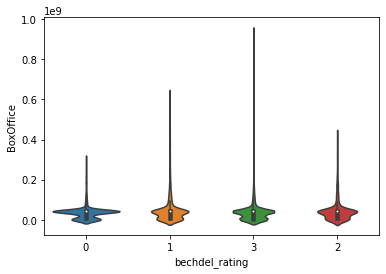

In [451]:
sns.violinplot(x = 'bechdel_rating', y = 'BoxOffice', data = final_df)
#Looks like there are some outliers, let's investigate

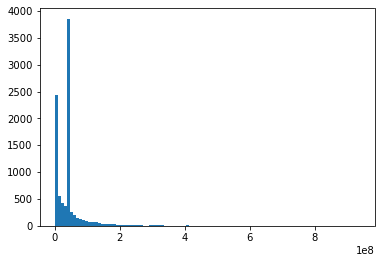

In [452]:
plt.hist(final_df['BoxOffice'], bins=100)
plt.show() 
#We can better see the impact of using the sample mean but it looks like there are still some extreme values.

In [553]:
final_df.sort_values(by=['BoxOffice'], ascending=False)
#Looks like these values are for huge box office hits, let's leave them since they are valid extreme values.

,title,imdbid,year,bechdel_rating,Released,Runtime,Country,imdbRating,imdbVotes,BoxOffice,CoProduction,DirectorGender,ActorGender,IsItGay,Runtime_NaN,imdbVotes_NaN,BoxOffice_NaN,bechdel_binary,log_BoxOffice
7757,Star Wars: The Force Awakens,2488496,2015,3,2015-12-18,138.0,United States,7.9,904569.0,936662225.0,0,Unknown,female,0,0,0,0,1,20.657833
8793,Avengers: Endgame,4154796,2019,3,2019-04-26,181.0,United States,8.4,1030512.0,858373000.0,0,male,male,0,0,0,0,1,20.570549
9211,Spider-Man: No Way Home,10872600,2021,3,2021-12-17,148.0,United States,8.5,555922.0,800588139.0,0,male,Unknown,0,0,0,0,1,20.500857
5445,Avatar,0499549,2009,3,2009-12-18,162.0,United States,7.9,1185150.0,760507625.0,0,male,female,0,0,0,0,1,20.449497
8529,Black Panther,1825683,2018,3,2018-02-16,134.0,United States,7.3,713245.0,700426566.0,0,male,female,0,0,0,0,1,20.367200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1144,Fahrenheit 451,0060390,1966,3,1966-11-14,112.0,United Kingdom,7.2,42989.0,509.0,0,male,female,0,0,0,0,1,6.232448
1009,Antoine and Colette,1180329,1962,0,1962-06-22,32.0,France,7.6,5165.0,509.0,0,male,Unknown,0,0,0,0,0,6.232448
976,Jules and Jim,0055032,1962,1,1962-01-23,105.0,France,7.7,40596.0,509.0,0,male,female,0,0,0,0,0,6.232448
878,"400 Blows, The",0053198,1959,0,1959-11-16,99.0,France,8.1,114819.0,509.0,0,male,female,0,0,0,0,0,6.232448


In [552]:
final_df['log_BoxOffice'] = np.log(final_df['BoxOffice'])
#But let's add a log variable for future analysis.

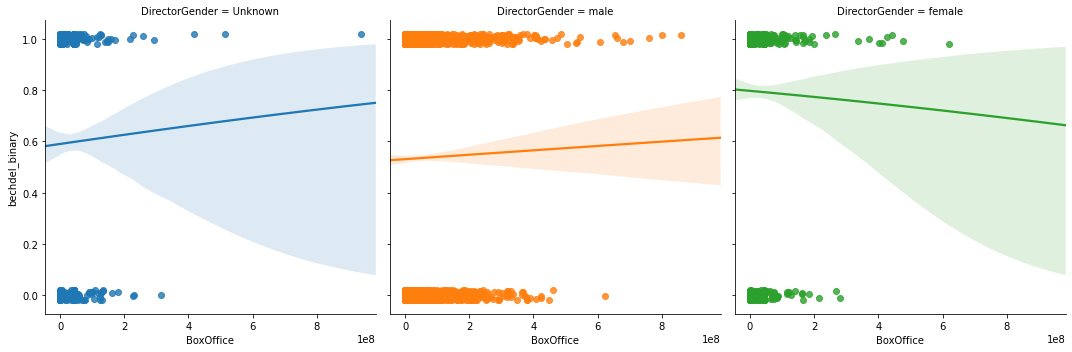

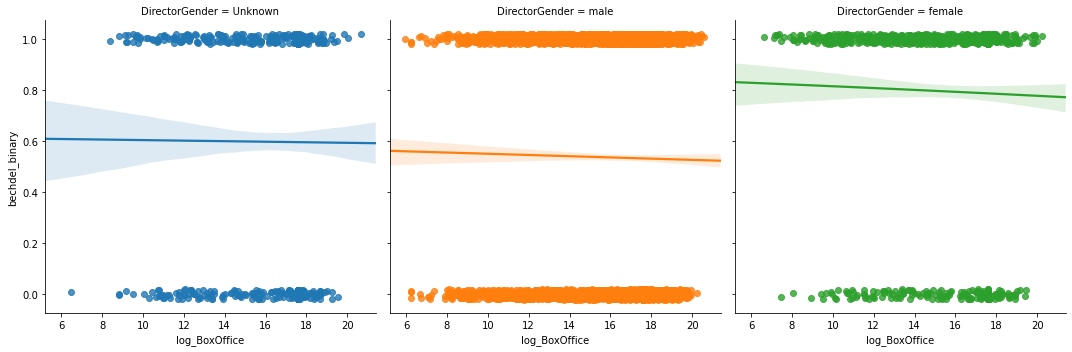

In [526]:
for value in final_df[['BoxOffice', 'log_BoxOffice']]:
    sns.lmplot(x = value,
                        y = "bechdel_binary",
                        col="DirectorGender", 
                        hue="DirectorGender",
                        data = final_df,
                        y_jitter=.02, 
                        logistic=True,
                        truncate=False)

Based on our logit models, it appears that the larger the box office earnings for a film, the less likely the film is to pass the Bechdel test (binary value). Female directors who direct films with larger box office earnings are less likely to pass the Bechdel test the larger their box office earnings are.

#### Question 2. Do women more direct films that score higher on the Bechdel test than men?

<AxesSubplot:xlabel='bechdel_rating', ylabel='count'>

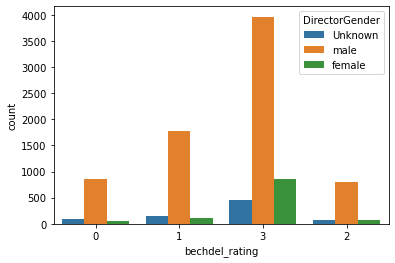

In [529]:
sns.countplot(data = final_df, x='bechdel_rating', hue='DirectorGender')

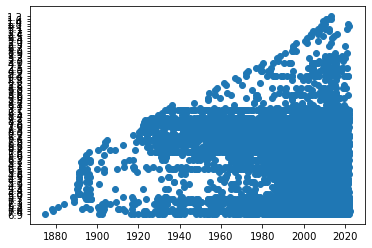

In [545]:
plt.scatter(data = final_df, x="Released", y="imdbRating")

#### Question 3. Do LGBT films have a higher Bechdel test than non-LGBT films?

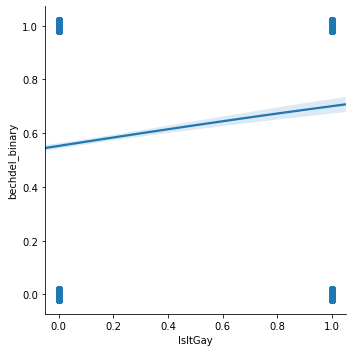

In [549]:
sns.lmplot(x = "IsItGay", y = "bechdel_binary",
                        data = final_df,
                        y_jitter=.02, 
                        logistic=True,
                        truncate=False)